<a href="https://colab.research.google.com/github/ricky-kiva/dl-deep-tf-cv-advanced/blob/main/1_l2_resnet50_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR-10 on ResNet50**

Import libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from matplotlib import pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw

import os, re, time, json
import numpy as np

Define classes

In [2]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Download **CIFAR10** dataset

In [3]:
(train_images, train_labels), (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


Set Matplotlib config

In [4]:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize='large', edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

Function: display images

In [5]:
def display_images(images, predictions, title):
    n = 10
    indexes = np.random.choice(len(predictions), size=n)

    n_images = images[indexes]
    n_predictions = (predictions[indexes]).reshape((n,))

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(10):
      ax = fig.add_subplot(1, 10, (i+1)) # add subplot to grid of (1x10) in each iteration
      class_index = n_predictions[i]
      plt.xlabel(classes[class_index])

      plt.yticks([])
      plt.xticks([])
      plt.imshow(n_images[i])

Function: display metrics

In [6]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history[f"val_{metric_name}"], color='green', label=f"val_{metric_name}")

Visualize dataset

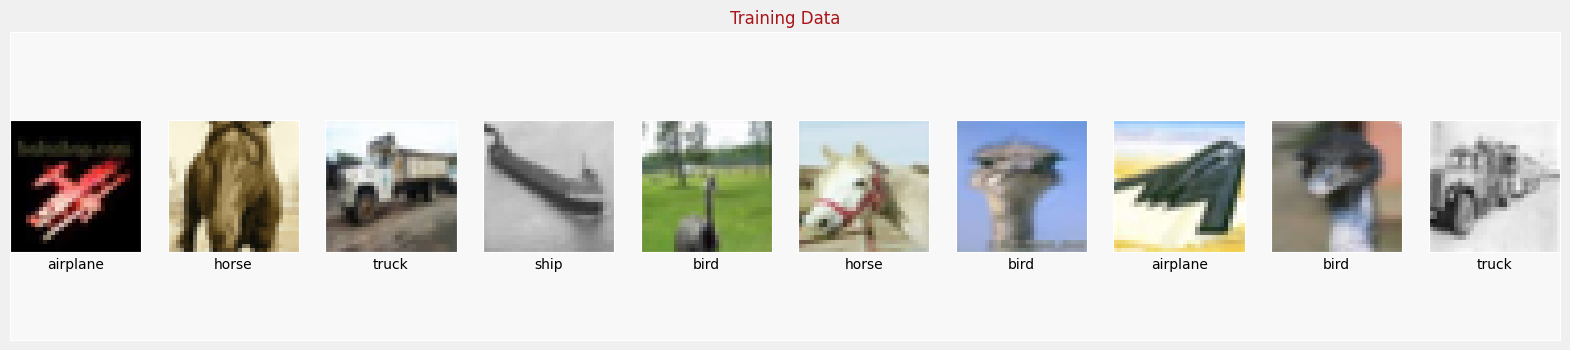

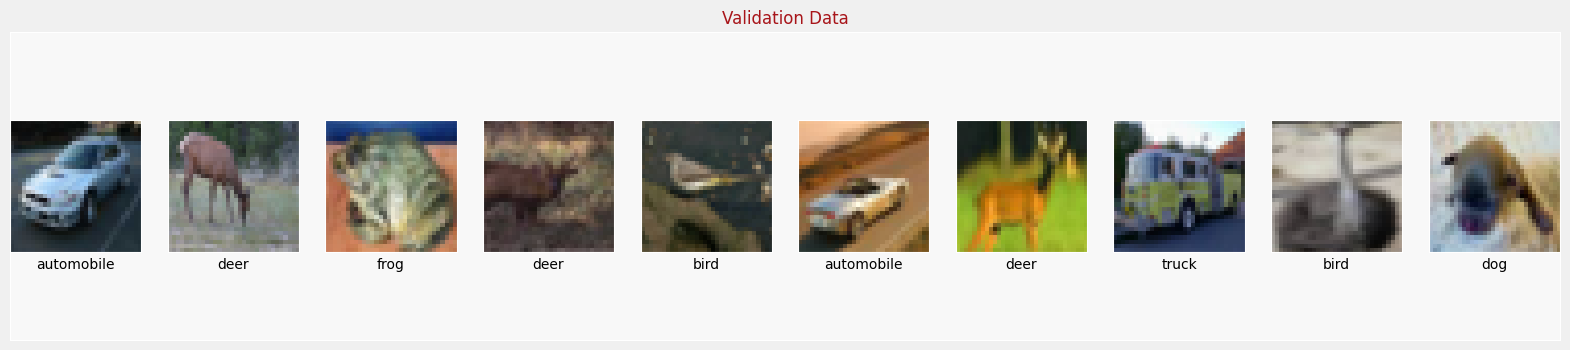

In [7]:
display_images(train_images, train_labels, "Training Data")
display_images(validation_images, validation_labels, "Validation Data")

Check image shape

In [8]:
print(f"Train shape: {train_images[0].astype('float32').shape}")
print(f"Validation shape: {validation_images[0].astype('float32').shape}")

Train shape: (32, 32, 3)
Validation shape: (32, 32, 3)


Function: Preprocess dataset

In [9]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32') # convert each RGB values to float
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

Preprocess *train* & *validation* image set

In [10]:
train_X = preprocess_image_input(train_images)
valid_X = preprocess_image_input(validation_images)

Defining the Network

Note: We will transfer learning **ResNet50**
- We'll load pre-trained **ImageNet weights** to the model
- We'll retain all layers of **ResNet50** along with the final classification layers

In [11]:
from tensorflow.keras import layers

def feature_extractor(inputs):
  feature_extractor = tf.keras.applications.resnet.ResNet50(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet')(inputs)

  return feature_extractor

def classifier(inputs):
  x = layers.GlobalAveragePooling2D()(inputs)
  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dense(10, activation='softmax', name='classification')(x)

  return x

def final_model(inputs):
  # Upsampling to (7,7) because ResNet50 shape is (224, 224) but CIFAR10 is (32, 32) (7 times of 224)
  resize = layers.UpSampling2D(size=(7,7))(inputs)

  resnet_feature_extractor = feature_extractor(resize)
  classification_output = classifier(resnet_feature_extractor)

  return classification_output

Function: Define compile model

In [12]:
def compile_model():
  inputs = layers.Input(shape=(32, 32, 3)) # `Input` to initiate Keras Tensor on the input

  classification_output = final_model(inputs)

  model = tf.keras.Model(inputs=inputs,
                         outputs=classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

Compile the model

In [13]:
model = compile_model()

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

Define train parameters

In [14]:
EPOCHS = 4
BATCH_SIZE = 64

Train the model

In [15]:
history = model.fit(train_X,
                    train_labels,
                    epochs=EPOCHS,
                    validation_data=(valid_X, validation_labels),
                    batch_size=BATCH_SIZE)

Epoch 1/4
782/782 [==============================] - 565s 687ms/step - loss: 0.4023 - accuracy: 0.8687 - val_loss: 0.2095 - val_accuracy: 0.9293
Epoch 2/4
782/782 [==============================] - 541s 692ms/step - loss: 0.1021 - accuracy: 0.9671 - val_loss: 0.1648 - val_accuracy: 0.9436
Epoch 3/4
782/782 [==============================] - 541s 691ms/step - loss: 0.0344 - accuracy: 0.9899 - val_loss: 0.1785 - val_accuracy: 0.9457
Epoch 4/4
782/782 [==============================] - 554s 708ms/step - loss: 0.0147 - accuracy: 0.9966 - val_loss: 0.1811 - val_accuracy: 0.9485


Evaluate the model

In [16]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=BATCH_SIZE)

157/157 [==============================] - 28s 179ms/step - loss: 0.1811 - accuracy: 0.9485


Plot *Loss* & *Accuracy*

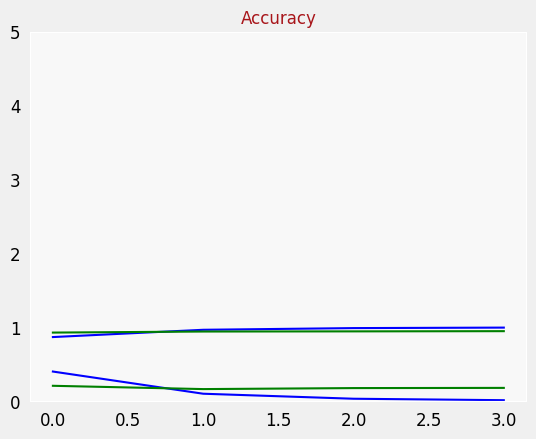

In [17]:
plot_metrics('loss', 'Loss')
plot_metrics('accuracy', 'Accuracy')

Visualize predictions

157/157 [==============================] - 26s 163ms/step


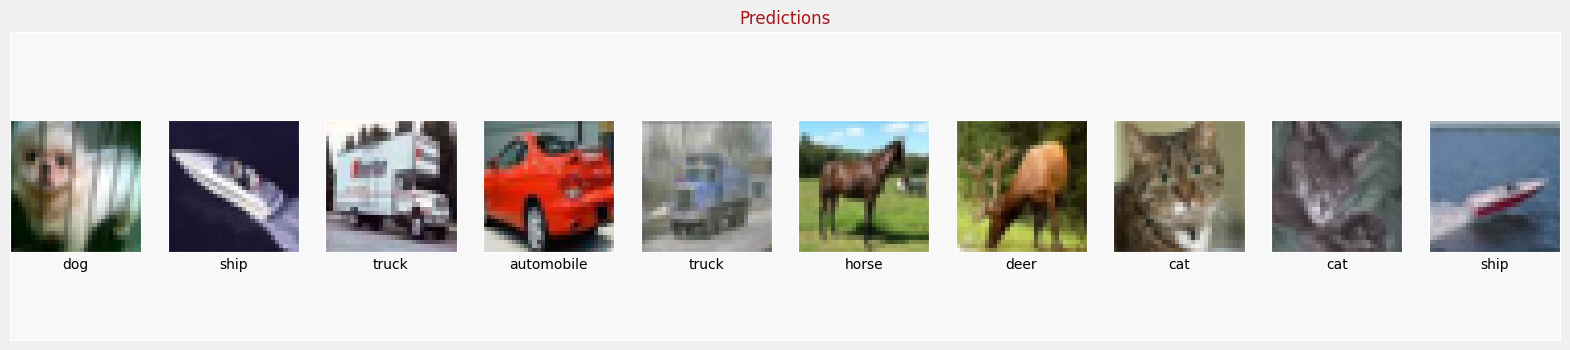

In [20]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis=1)

display_images(validation_images, probabilities, "Predictions")